# 다양한 데이터 타입 다루기
이 장에서는 스파크의 구조적 연산에서 가장 중요한 내용인 표현식을 만들고, 다양한 데이터 타입을 다루는 방법에 대해 알아봅시다.
* 불리언 타입
* 수치 타입
* 문자열 타입
* date와 timestamp 타입
* null값 다루기
* 복합 데이터 타입
* 사용자 정의 함수

## API는 어디서 찾을끼?
나중에 버전이 바뀌고 바뀌어도, Spark의 데이터 변환용 함수를 찾기 위해 핵심적으로 다뤄야할 부분은 다음과 같습니다.
* DataFrame(Dataset) 메서드
* Column Method

In [2]:
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("./data/retail-data/by-day/2010-12-01.csv")

#### 데이터 해석
```
< 소매 데이터 > 
root
 |-- InvoiceNo: string (nullable = true) # 송장 번호
 |-- StockCode: string (nullable = true) # 상품 코드
 |-- Description: string (nullable = true) # 설명 ( 구체적인 상품 명 )
 |-- Quantity: integer (nullable = true)  # 수량
 |-- InvoiceDate: string (nullable = true) # 송장 날짜
 |-- UnitPrice: double (nullable = true) # 단가
 |-- CustomerID: double (nullable = true) # 고객 ID
 |-- Country: string (nullable = true) # 국가
 
```

In [3]:
df.show(2)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 2 rows



In [4]:
df.groupBy("StockCode").count().show(2)
df.groupBy("CustomerID").count().show(2)

+---------+-----+
|StockCode|count|
+---------+-----+
|    22728|    4|
|    21889|    5|
+---------+-----+
only showing top 2 rows

+----------+-----+
|CustomerID|count|
+----------+-----+
|   15311.0|   36|
|   16539.0|   21|
+----------+-----+
only showing top 2 rows



In [5]:
df.createOrReplaceTempView("dfTable") # 데이터프레임에 SQL을 적용시킬 수 있는 객체를 별도 생성

In [6]:
df.show(2)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 2 rows



## 스파크 데이터 타입으로 변환하기
* 데이터 타입 변환은 `lit` 함수를 사용합니다. lit 함수는 다른 언어의 데이터 타입을 스파크 데이터 타입에 맞게 변환한다.
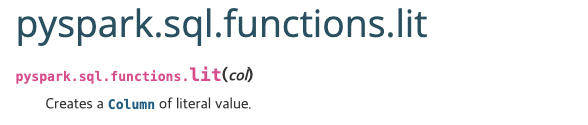

In [7]:
from pyspark.sql.functions import lit
df.select(lit(5), lit("five"), lit(5.0))

DataFrame[5: int, five: string, 5.0: double]

## 불리언 데이터 타입 다루기
* 불리언은 and, or, true, false 로 구성된다. 
* 불리언 식에는 일치조건 뿐만 아니라 작다, 크다 같은 비교 연산 조건을 사용할 수 있다.

In [8]:
from pyspark.sql.functions import col
df.where(col("InvoiceNo")!=536365)\
.select("InvoiceNo", "Description")\
.show(3, False)

+---------+-----------------------------+
|InvoiceNo|Description                  |
+---------+-----------------------------+
|536366   |HAND WARMER UNION JACK       |
|536366   |HAND WARMER RED POLKA DOT    |
|536367   |ASSORTED COLOUR BIRD ORNAMENT|
+---------+-----------------------------+
only showing top 3 rows



가장 명확한 방법은 문자열 표현식에 조건절을 명시하는 것이다.

In [9]:
df.where("InvoiceNo = 536366").show(3, False)


+---------+---------+-------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description              |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-------------------------+--------+-------------------+---------+----------+--------------+
|536366   |22633    |HAND WARMER UNION JACK   |6       |2010-12-01 08:28:00|1.85     |17850.0   |United Kingdom|
|536366   |22632    |HAND WARMER RED POLKA DOT|6       |2010-12-01 08:28:00|1.85     |17850.0   |United Kingdom|
+---------+---------+-------------------------+--------+-------------------+---------+----------+--------------+



In [10]:
df.where("InvoiceNo <> 536366").show(3, False)

+---------+---------+----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+----------------------------------+--------+-------------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER|6       |2010-12-01 08:26:00|2.55     |17850.0   |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN               |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER    |8       |2010-12-01 08:26:00|2.75     |17850.0   |United Kingdom|
+---------+---------+----------------------------------+--------+-------------------+---------+----------+--------------+
only showing top 3 rows



`and`, `or` 메서드를 사용해 불리언 표현식을 여러 부분에 지정할 수 있다. 불리언 표현식을 사용하는 경우 항상 모든 표현식을 and 메서드로 묶어 차례대로 적용해야한다.

????
차례대로 필터를 적용해야하는 이유는 다음과 같다. 불리언문을 차례대로 표현해도 스파크는 내부적으로 and 구문을 필터 사이에 추가해 모든 필터를 하나의 문장으로 변환한다. 그런 다음 동시에 모든 필터를 처리한다. 
원한다면 and 구문으로 조건문을 만들 수 있다. 하지만 차례로 조건을 나열하면 쉽다. 반면 or 구문을 사용할때는 반드시 동일한 구문에 조건을  정의해야한다.

➡️ and 연산에는 순서를 주의하고 or 연산은  평등하니 순서에 주의하지 않아도 된다는 의미

In [13]:
from pyspark.sql.functions import instr

DOTCodeFilter = col("StockCode")=="DOT"
priceFilter = col("UnitPrice")> 600
descripFilter = instr(col("Description"), "POSTAGE")>=1 # POSTAGE : 우편요금

df.withColumn("isExpensive", DOTCodeFilter & (priceFilter | descripFilter))\
.where("isExpensive")\
.show(2)

df.withColumn("isExpensive", DOTCodeFilter & (priceFilter | descripFilter))\
.where("isExpensive")\
.select("unitPrice", "isExpensive").show(2)



+---------+---------+--------------+--------+-------------------+---------+----------+--------------+-----------+
|InvoiceNo|StockCode|   Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|isExpensive|
+---------+---------+--------------+--------+-------------------+---------+----------+--------------+-----------+
|   536544|      DOT|DOTCOM POSTAGE|       1|2010-12-01 14:32:00|   569.77|      null|United Kingdom|       true|
|   536592|      DOT|DOTCOM POSTAGE|       1|2010-12-01 17:06:00|   607.49|      null|United Kingdom|       true|
+---------+---------+--------------+--------+-------------------+---------+----------+--------------+-----------+

+---------+-----------+
|unitPrice|isExpensive|
+---------+-----------+
|   569.77|       true|
|   607.49|       true|
+---------+-----------+



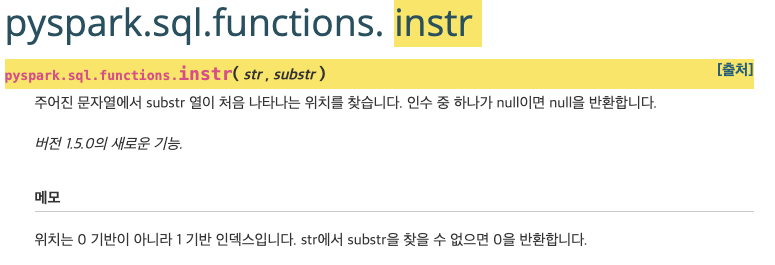

In [14]:
from pyspark.sql.functions import expr

df.withColumn("isExpensive",expr("NOT UnitPrice <=250"))\
.where("isExpensive")\
.select("Description", "UnitPrice").show(2)

+--------------+---------+
|   Description|UnitPrice|
+--------------+---------+
|DOTCOM POSTAGE|   569.77|
|DOTCOM POSTAGE|   607.49|
+--------------+---------+



> 불리언 표현식을 만들때 null 값 데이터는 
null-safe 동치 테스트를 수행하는 예제이다.
`df.where(col("Description").eqNullSafe("hello")).show()`


## 수치 데이터 타입 다루기
* `count` 
* `pow` : 표시된 지수만큼 컬럼의 값을 거듭제곱한다.

In [ ]:
from pyspark.sql.functions import expr, pow

fabricatedQuantity = pow(col("Quantity")*col("UnitPrice"),2)+5

In [ ]:
# 수치형: 곱셈, 덧셈, 뺼셈이 가능하다.
df.select(expr("CustomerID"), fabricatedQuantity.alias("realQuantity")).show(2)

In [ ]:
df.selectExpr("CustomerID",
             "(POWER((Quantity*UnitPrice), 2.0)+5) as realQuantity"
             ).show(2)

반올림도 자주 사용하는 수치형 작업 중 하나이다. 때로는 소수점 자리를 없애기 위해 Integer 데이터 타입으로 형변환하기도 한다. Spark 는 정확한 계산이 가능한 함수를 제공한다. 그리고 정밀도를 사용해 더 세밀한 작업을 수행할 수 있다.

In [ ]:
# 소수점 첫째자리에서 반올림하는 예제
from pyspark.sql.functions import lit, round, bround
df.select(round(col("UnitPrice"),1).alias("rounded"), col("UnitPrice")).show(2)

기본적으로 `round` 함수는 소수점 값이 정확히 중간값 이상이라면 반올림합니다. 내림을 `bround` 함수를 사용합니다.

In [ ]:
from pyspark.sql.functions import lit, round, bround
df.select(round(lit("2.5")), bround(lit("2.5"))).show(2)

두 칼럼 사이에 상관관계를 계산하는 것도 

수치형 연산작업 중 하나이다. 예를 들어 고객이 비싼 물건보다 저렴한 물건을 더 많이 구매하는지 알기 위해 두 칼럼에 대한 피어슨 상관계수를 계산할 필요가 있다. 다음 예제와 같이 통계함수나 메소드를 사용해 피어슨 상관계수를 계산할 수 있다.
> 피어슨 상관계수는 두 변수가 서로 선형 상관관계를 가지는지 확인하는 척도이다.

In [ ]:
from pyspark.sql.functions import  corr
df.stat.corr("Quantity", "UnitPrice")

요약 통계는 `describe` 메소드를 사용해 얻을 수 있다. `describe` 메소드는 관련 컬럼에 대한 집계(count), 평균(mean), 표준편차(stddev), 최솟값(min), 최댓값(max)를 계산한다.

In [ ]:
df.describe().show()

정확한 수치가 필요하면 함수를 임포트하고 해당 컬럼에 적용하는 방식으로 직접 집계를 수행할 수 있다.

In [ ]:
from pyspark.sql.functions import count, mean, stddev_pop, min,max


StatFunctions 패키지는 다양한 통계함수를 제공한다. `stat` 속성을 사용해 접근할 수 있고,
다양한 통곗값을 계산할 떄 사용하는 DataFrame 메소드이다. 
예를들어 `approxQuantile` 메소드를 사용해 데이터의 백분위수를 정확하게 계산하거나 근사치를 계산할 수 있다.

In [ ]:
colName ="UnitPrice"
quantileProbs = [0.5]
relError = 0.05
df.stat.approxQuantile("UnitPrice", quantileProbs, relError) #2.51


StatFunctions 패키지는 교차표나 자주 사용하는 항목상을 확인하는 용도의 메소드도 제공합니다.


In [ ]:
df.stat.crosstab("StockCode", "Quantity").show(2)

In [ ]:
df.stat.freqItems(["StockCode", "Quantity"]).show(2, False)

마지막으로 `monotonically_increasing_id`함수는 모든 로우에 고유 ID값을 추가합니다. 이 함수는 모든 로우에 0부터 시작하는 고윳값을 생성합니다.

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id
df.select(monotonically_increasing_id()).show(2)


## Working with Strings
문자열을 다루는 작업은 모든 데이터 처리 과정에서 발생한다. 그러므로 문자열을 다루는 방법을 알아야한다. 로그파일에 정규표현식을 사용해 데이터 추출, 데이터 치환, 문자열 존재여부, 대, 소문자 변화나 처리 등의 작업을 할 수 있다.

대/소문자 변환작업부터 해보자. `initcap` 함수는 주어진 문자열에서 공백으로 나뉘는 모든 단어의 첫 글자를 대문자로 변경한다.

In [ ]:
from pyspark.sql.functions import initcap
df.select(initcap(col("Description"))).show()

`lower` , `upper` 함수를 이용해 문자열 전체를 소문자로 변경하거나 대문자로 변경할 수 있다.

In [ ]:
from pyspark.sql.functions import lower, upper
df.select(col("Description"), lower(col("Description")),\
upper(lower(col("Description")))).show(2)

문자열 주변의 공백을 제거하거나 추가하는 작업도 가능하다. 이 작업은 `lpad`, `ltrim`, `rpad`, `rtrim`, `trim` 함수를 이용한다.

In [ ]:
from pyspark.sql.functions import lit, ltrim, rtrim, rpad, lpad, trim

df.select(
ltrim(lit("    HELLO   ")).alias("ltrim"),
rtrim(lit("    HELLO   ")).alias("ltrim"),
trim(lit("    HELLO   ")).alias("ltrim"),
lpad(lit("HELLO"),3," ").alias("lp"),
rpad(lit("HELLO"),10," ").alias("rp")).show(2)

`lpad` 함수나 `rpad` 함수의 문자열 길이보다 작은 숫자를 넘기면 문자열의 오른쪽부터 제거된다.

#### Regular Expressions
문자열의 존재여부를 확인하거나  모든 문자열을 치환할 때는 보통 **정규표현식(Regular Expression)** 을 사용합니다. 정규 표현식을 사용해 문자열에서 값을 추출하거나 다른 값으로 치환하는데 필요한 규칙 모음을 정의할 수 있다.

Spark 는 Java  정규 표현식이 가진 강력한 능력을 활용합니다. Spark는 정규 표현식을 위해 `regexp_extract` 함수와 `regexp_replace` 함수를 제공합니다. 이 함수들은 값을 추출하고 치환한다.



In [ ]:
# regexp_replace 힘수를 사용해 description 컬럼을 COLOR 로 치환해보겠습니다.
from pyspark.sql.functions import regexp_replace
regex_string="BLACK|WHITE|RED|GREEN|BLUE"
df.select(
regexp_replace(col("Description"), regex_string, "COLOR").alias("color_clean"),\
    col("Description")).show(2)


주어진 문자를 다른 문자로 치환해야할 때가 있습니다. `translate`를 이용해 치환해보겠습니다. 이 연산은 문자 단위로 이뤄집니다. 교체 문자열에서 색인된 문자열에서 색인된 문자에 해당하는 모든 문자를 치환한다.

In [ ]:
from pyspark.sql.functions import translate
df.select(translate(col("Description"), "LEFT", "1337"), \
          col("Description")).show(2)

처음 나타난 색상 이름을 추출하는 것과 같은 작업을 수행할 수 있다.


In [ ]:
from pyspark.sql.functions import regexp_extract
extract_str = "(BLACK|WHITE|RED|GREEN|BLUE)"
df.select(
regexp_extract(col("Description"), extract_str,1).alias("color_clean"),
col("Description")
).show(2)

때로는 값 추출 없이 단순히 값의 존재 여부를 확인하고 싶을 떄가 있다. 이때는 `contains` 메소드를 이용한다. 이 메소드는 인수로 입력된 값이 칼럼의 문자열에 존재하는지 불리언타입으로 반환합니다.

In [ ]:
from pyspark.sql.functions import instr
containsBlack = instr(col("Description"), "BLACK")>=1
containsWhite = instr(col("Description"), "WHITE")>=1
df.withColumn("hasSimpleColor", containsBlack | containsWhite)\
.where("hasSimpleColor")\
.select("Description").show(3, False)

위 예제는 값을 두 개만 쓰기 때문에 간단해보이지만, 값의 개수가 늘어나면 복잡해진자.
동적으로 인수의 개수가 변하는 상황을 Spark 가 어떻게 처리하는지 알아보자. 값 목록을 인수로 변환해 함수에 전달할 때 `varargs`를 활용한다.

`locate` 함수는 쉽게 확장할 수 있다. 따라서 칼럼이나 불리언 필터를 프로그래밍 방식으로 생성할 수있다. 예를 들어 `locate` 함수를 확장해 입력값의 최소공배수를 구하거나 소수 여부를 판단할 수 있다.


In [ ]:
from pyspark.sql.functions import expr, locate
simpleColors = ["black", "white", "red", "green", "blue"]
def color_locator(column, color_string):
    return locate(color_string.upper(), column)\
         .cast("boolean").alias("is_"+color_string)
selectColumns = [color_locator(df.Description,c) for c in simpleColors]
selectColumns.append(expr("*")) # column 타입이어야한다.

df.select(*selectedColumns).where(expr("is_white OR is_red"))\
.select("Description").show(2, False)

## Working with Dates and Timestamps
Spark 는 두 가지 종류의 시간 정보만 관리한다. 
* 달력 형태의 날짜 (date)
* 날짜와 시간 정보를 가지는 타임스탬프(tinmestamp)

Spark는 `inferSchema` 옵션이 활성화된 경우, 날짜와 타임스탬프를 포함해 칼럼의 데이터 타입을 정확하게 식별하려 시도한다. Spark는 특정 날짜 포맷을 명시하지 않아도 자체적으로 식별해 데이터를 읽을 수 있다. 따라서 예제의 데이터셋이 잘 동작하는 것을 확인할 수 있다.


Spark는 특정 시점에서 데이터 포맷이 약간 특이하게 변할 수 있다. 이 문제를 피하려면 파싱이나 변환 작업을 해야한다. Spark는 Java의 날짜와 타임스탬프를 이용해 표준 체계를 따른다. 다음은 오늘 날짜와 현재 타임스탬프를 구하는 예제이다.

In [ ]:
from pyspark.sql.functions import current_date, current_timestamp

dateDF = spark.range(10)\
.withColumn("today", current_date())\
.withColumn("now", current_timestamp())

dateDF.createOrReplaceTempView("dateTable")

In [ ]:
dateDF.show(2)

위 예제로 DataFrame을 사용해 오늘을 기준으로 5일 전후의 날짜를 구현해보자. `date_sum` 함수와 `date_add` 함수는 컬럼과 더하거나 뺄 날자의 수를 인수로 전달해야한다.


In [ ]:
from pyspark.sql.functions import date_add, date_sub
dateDF.select(date_sub(col("today"),5), date_add(col("today"),5))\
.show(3)

두 날짜의 차이를 구하는 작업도 자주 발생한다. 두 날짜 사이의 일수를 반환하는 `datediff`함수를 사용해 이 작업을 수행할 수있다. 월별로 일수가 달라 날짜만 신경쓰는 경우가 많지만,  두 날짜 사이의 개월수를 반환하는 `months_between` 함수도 있다.

In [ ]:
from pyspark.sql.functions import datediff, months_between, to_date
dateDF.withColumn("week_ago", date_sub(col("today"),7))\
.select(datediff(col("week_ago"), col("today"))).show(1)

dateDF.select(
to_date(lit("2016-01-01")).alias("start"),
    to_date(lit("2017-05-22")).alias("end"))\
.select(months_between(col("start"), col("end"))).show(2)

`to_date` 함수는 문자열을 날짜로 변환할 수 있고, 필요에 따라 날짜 포맷도 지정할 수 있다. 


In [ ]:
from pyspark.sql.functions import to_date, lit
spark.range(5).withColumn("date", lit("2017-02-01"))\
.select(to_date(col("date"))).show(3)

SPARK는 날짜를 파싱할 수 없다면 에러대신 null값을 반환한다. 그래서 다단계 처리 파이프라인에서 까다로울 수 있다. 데이터 포맷이 지정된 데이터에서 또 다른 포맷의 데이터가 나올 수 있기때문이다.
날짜의 혼돈을 피하기 위해 `to_date`와 `to_timestamp` 함수를 사용합니다. `to_timestamp` 함수는 반드시 날짜 포맷을 지정해야한다.

In [ ]:
from pyspark.sql.functions import to_date

dateFormat = "yyyy-dd-MM"

cleanDateDF = spark.range(1).select(
    to_date(lit("2017-12-11"), dateFormat).alias("date"),
    to_date(lit("2017-20-12"), dateFormat).alias("date2"))

cleanDateDF.createOrReplaceTempView("dateTable2")

cleanDateDF.show()

항상 날짜 포맷을 지정해야하는 `to_timestamp` 함수의 예제도 보자.


In [ ]:
from pyspark.sql.functions import to_timestamp
cleanDateDF.select(to_timestamp(col("date"), dateFormat)).show()

모든 언어에서 날짜와 타임스탬프간의 변환은 간단하다. SQL 에서는 다음과 같은 방식을 이용한다.
```
SELECT cast(to_date("2017-01-01", "yyyy-dd-MM") as timestamp)
```
올바른 포맷과 타입의 날짜와 타임스탬프를 사용하면 매우 쉽게 비교할 수 있다. 날짜를 비교할 때는 날짜와 타임스탬프를 이용하거나 yyyy-mm-dd 포맷에 맞는 문자열을 지정한다.

In [ ]:
cleanDateDF.filter(col("date2") > lit("2017-12-12")).show()

SPARK 가 리터럴로 인식하는 문자열을 지정해 날짜를 비교할 수 있다.

In [ ]:
cleanDateDF.filter(col("date2") > "'2017-12-12'").show() # 안되는디여

## Working with Nulls in Data
* DataFrame에서 빠져있거나 비어있는 데이터를 표현할 때는 항상 null값을 이용하는 것이 좋다. * Spark 에서 빈 문자열이나 대체 값 대신 null을 이용해야 최적화를 수행할 수 있다. null 값을 다루는 두 가지 방법이 있다. 명시적으로 null값을 제거하거나, 전역 또는 컬럼 단위로 null 값을 특정 값으로 채워넣는 것이다.

#### Colaesce
Spark의 `coalesce` 함수는 이수로 지정한 여러 컬럼 중 Null이 아닌 첫번째 값을 반환한다. 모든 컬럼이 Null이 아닌 값을 가지는 첫 번쨰의 컬럼 값을 반환한다.

In [ ]:
from pyspark.sql.functions import coalesce
df.select(coalesce(col("Description"), col("CustomerID"))).show(3,False)

#### ifnull, nullIf, nvl, and nvl2
`coalesce` 함수와 유사한 결과를 얻을 수 있는 SQL 함수가 있다. 
이 함수들은 DataFrmae의 `select` 표현식으로 사용할 수 있다.
* `ifnull` 함수는 첫 번째 값이 null 이면 두 번째 값을 반환한다. 첫 번째 값이 null 이 아니면 첫 번째 값을 반환한다. 
*  `nullif` 함수는 두 값이 같으면 null을 반환한다. 두 값이 다르면 첫번째 값을 반환한다.
* `nvl` 함수는 첫 번째 값이 null이면 두 번째 값을 반환한다. 첫 번째 값이 null 이 아니면 펏 번째 값을 반환한다.
* `nvl2` 함수는 첫 번쨰 값이 null 이 아니면 두 번째 값을 반환한다. 그리고 첫 번쨰 값이 null 이면 세 번쨰 인수로 지정된 값을 반환한다.
```
SELECT 
  ifnull(null, 'return_value'),
  nullif('value','value'),
  nvl(null,'return_value'),
  nvl2('not_null','return_value','else_value')
FROM dfTable LIMIT 1

```
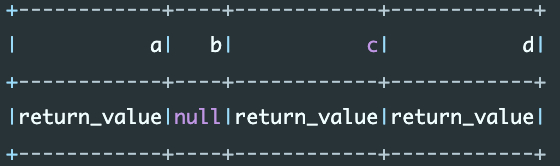

#### drop
`drop` 메소드는 null값을 가진 로우는 제거하는 가장 간단한 함수이다. 기본적으로 Null을 가지는 모든 로우를 제거합니다.
* `drop` 메소드 인수로 `any`로 지정한 경우, 로우의 컬럼값 중 하나로 null값을 가진다면 해당 로우를 제거한다.
* `all` 을 지정하면, 모든 컬럼 값이 null 이거나 NaN인 경우에만 해당 로우를 제거한다.
* `drop` 메소드에 배열 형태의 컬럼을 인수로 전달해 적용할 수 있다.

In [ ]:
df.na.drop()
df.na.drop("any")
df.na.drop("all")
df.na.drop("all", subset=["StockCode", "InvoiceNo"])


#### fill 
`fill` 함수를 사용해 하나 이상의 컬럼을 특정 값을 채울 수 있다. 채워넣을 값과 컬럼의 집합으로 구성된 맵을 인수로 사용한다.

In [ ]:
df.na.fill("all", subset=["StockCode", "InvoiceNo"])

In [ ]:
fill_cols_vals = {"StockCode":5, "Description":"No Value"}
df.na.fill(fill_cols_vals)

#### replace 

`drop` 메소드와 `fill` 메소드 외에도 Null 값을 유연하게 대처할 방법이 있다. 
조건에 따라 다른 값으로 대체하는 것이다. `replace` 를 사용해 변경하고자 하는 값과 원래 값의 데이터 타입이 같아야한다.

In [ ]:
df.na.replace([""],["UNKONW"], "Description")

## Ordering
`asc_nulls_first`, `desc_nulls_first`, `asc_nulls_last`, `desc_nulls_last`함수를 사용해 DataFrame을 정렬할 때 null값이 표시되는 기준을 지정할 수 있다.

## Working with Complex Types
복합 데이터 타입에는 구조체, 배열, 맵이 있다.

### Structs
구조체는 DataFrame 내부의 DataFrame으로 생각할 수 있다. 쿼리문에서 다수의 컬럼을 괄호로 묶어 구조체를 만들 수 있다.

In [ ]:
from pyspark.sql.functions import struct
complexDF = df.select(struct("Description", "InvoiceNo").alias("complex"))
complexDF.createOrReplaceTempView("complexDF")
complexDF.show(2, False)

복합 데이터 타입을 가진 DataFrame으로 다른 DataFrame을 조회하는 것과 동일하게 사용할 수있다. 
* 유일한 차이점은 문법에 `.`  점 을 사용하거나, `getField` 메소드를 사용.
* `*` 문자를 사용해 모든 값을 조회할 수 있고, 모든 컬럼을 DataFrame의 최상위 수준으로 끌어올릴 수 있다.

In [ ]:
complexDF.select("complex.Description").show(2,False)
complexDF.select("complex.InvoiceNo").show(2,False)
complexDF.select(col("complex").getField("Description")).show(1,False)
complexDF.select("complex.*").show(3,False)

### Arrays
데이터에서 `Description` 칼럼의 모든 단어를 하나의 로우를  변환한다. `Description` 칼럼을 복합 데이터 타입인 배열로 변환한다.

#### split
* 배열로 변환하려면 `split` 함수를 사용한다. `split` 함수에 구분자를 인수로 전달해 배열로 변환한다.
* `split` 함수는 SPARK에서 복합 데이터 타입을 마치 또 다른 컬럼처럼 다룰 수 있는 매우 강력한 기능이다.


In [ ]:
from pyspark.sql.functions import split

df.select(col("Description")).show(2,False)
df.select(split(col("Description"), " ")).show(2,False)
df.select(split(col("Description")," ").alias("array_col"))\
.selectExpr("array_col[0]").show(2,False)

#### Array Length : size
배열의 크기를 조회해 배열의 길이를 알 수 있다.

In [ ]:
from pyspark.sql.functions import size
df.select(size(split(col("Description")," "))).show(2,False)

#### array_contains
`array_contains` 함수를 사용해 배열에 특정 값이 존재하는지 확인할 수 있다.

In [ ]:
from pyspark.sql.functions import array_contains
df.select(array_contains(split(col("Description")," "), "WHITE")).show(2)

복합 데이터 타입의 배열에 존재하는 모든 값을 로우로 변환하려면 `explode` 함수를 이용한다.
#### explode
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.explode.html

`explode` 함수는 배열 타입의 칼럼을 입력받는다. 그리고 입력된 칼럼의 배열값에 포함된 모든 값을 로우로 변환한다. 나머지 컬럼 값은 중복돼 표시한다. `Example 1`은 처리과정을 보여준다.
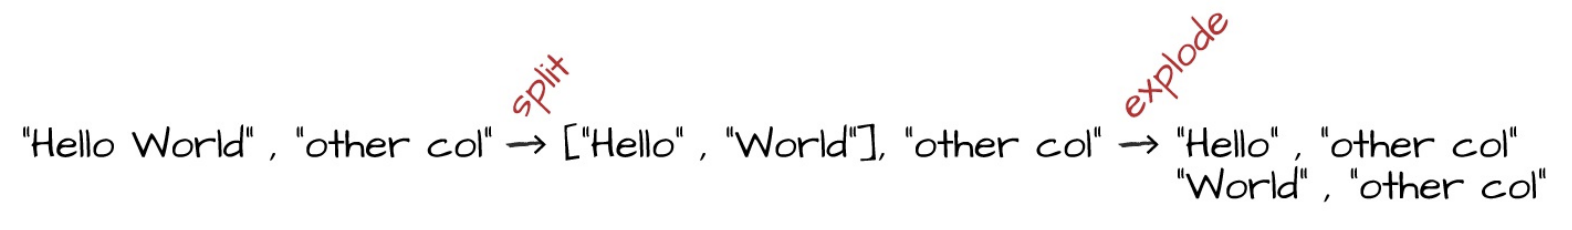

In [ ]:
from pyspark.sql.functions import split, explode
df.withColumn("splitted", split(col("Description")," "))\
.withColumn("exploded", explode(col("splitted")))\
.select("Description", "InvoiceNo","exploded").show(3,False)

#### Maps
맵은 `map` 함수의 컬럼의 Key-Value 쌍을 이용해 생성한다. 그리고 배열과 동일한 방법으로 값을 선택할 수 있다.

In [ ]:
df.show(2, False)

In [ ]:
from pyspark.sql.functions import create_map
df.select(create_map(col("Description"), col("InvoiceNo")).alias("complex_map")).show(3,False)

적합한 키를 사용해 데이터를 조회할 수있고, 해당 키가 없다면 null 값을 반환한다.

In [ ]:
df.select(create_map(col("Description"),col("InvoiceNo")).alias("complex_map")).show(1,False)

In [ ]:
df.select(create_map(col("Description"),col("InvoiceNo")).alias("complex_map"))\
.selectExpr("complex_map['WHITE METAL LANTERN']").show(2,False)

`map` 타입을 분해하여 칼럼으로 변환할 수 있다.

In [ ]:
df.select(create_map(col("Description"), col("InvoiceNo")).alias("complex_map"))\
.selectExpr("explode(complex_map)").show(2,False)

## Working with JSON
Spark는 JSON 데이터를 다루기 위한 몇 가지 고유 기능을 지원합니다. Spark에서 문자열 형태의 JSON을 조작할 수 있고, JSON을 파싱하거나 JSON 객체로 만들 수 있습니다.
다음은 JSON 칼럼을 생성하는 예제이다.


In [ ]:
jsonDF= spark.range(1).selectExpr("""
'{"myJSONKey": {"myJSONValue" : [1, 2, 3]}}' as jsonString
""")

`get_json_object` 함수는 JSON객체를 인라인 쿼리로 조회할 수 있습니다. 중첩이 없는 단일 수준의 JSON객체라면 `json_tuple`을 사용할 수 있습니다.


In [ ]:
from pyspark.sql.functions import get_json_object, json_tuple
jsonDF.select(
 get_json_object(col("jsonString"), "$.myJSONKey.myJSONValue[1]").alias("column"),
 json_tuple(col("jsonString"), "myJSONKey")).show(1,False)



```

# sql문
jsonDF.selectExpr(
  "json_tuple(jsonString, '$.myJSONKey.myJSONValue[1]') as column").show(2)

```

`to_json` 함수를 사용해 `StructType`을 JSON 문자열로 변경할 수 있다.

In [ ]:
from pyspark.sql.functions import to_json
df.selectExpr("(InvoiceNo, Description) as myStruct")\
.select(to_json(col("myStruct")))

`from_json`함수는 파라미터로 반드시 스키마를 지정해야한다.

In [ ]:
from pyspark.sql.functions import from_json
from pyspark.sql.types import *

parseSchema = StructType((
StructField("InvoiceNo", StringType(), True),
StructField("Description", StringType(),True)))


df.selectExpr("(InvoiceNo, Description) as myStruct")\
.select(to_json(col("myStruct")).alias("newJSON"))\
.select(from_json(col("newJSON"), parseSchema), col("newJSON")).show(2,False)

## User-Defined Functions
SPARK의 가장 강력한 기능 중 하나는 **사용자 정의 함수(User Defined Function, UDF)** 를 사용할 수 있다는 것입니다. 
UDF는 Python 이나 Scala 그리고 외부 라이브러리를 이용해 사용자가 원하는 형태로 트랜스포메이션을 만들 수 있게 합니다.


UDF는 레코드별로 데이터를 처리하는 함수이기 때문에 독특한 포맷이나 도메인에 특화된 언어를 사용하지 않는다. 이러한 UDF는 기본적으로 SparkSession이나 Context에서 사용할 수 있도록 임시 함수 형태로 등록한다.


Python 으로 함수를 작성했다면, 다르게 동작한다. SPARK는 워커노드에 Python 프로세스를 실행하고, Python이 이해할 수 있는 포맷으로 모든 데이터를 직렬화한다. 그리고 파이썬 프로세스에 있는 데이터의 로우마다 함수를 실행하고 마지막으로 JVM과 Spark 에 처리 결과를 반환한다.



* Function seririalized & sent to workers
* Spark starts python process and sends data
* python returns answer
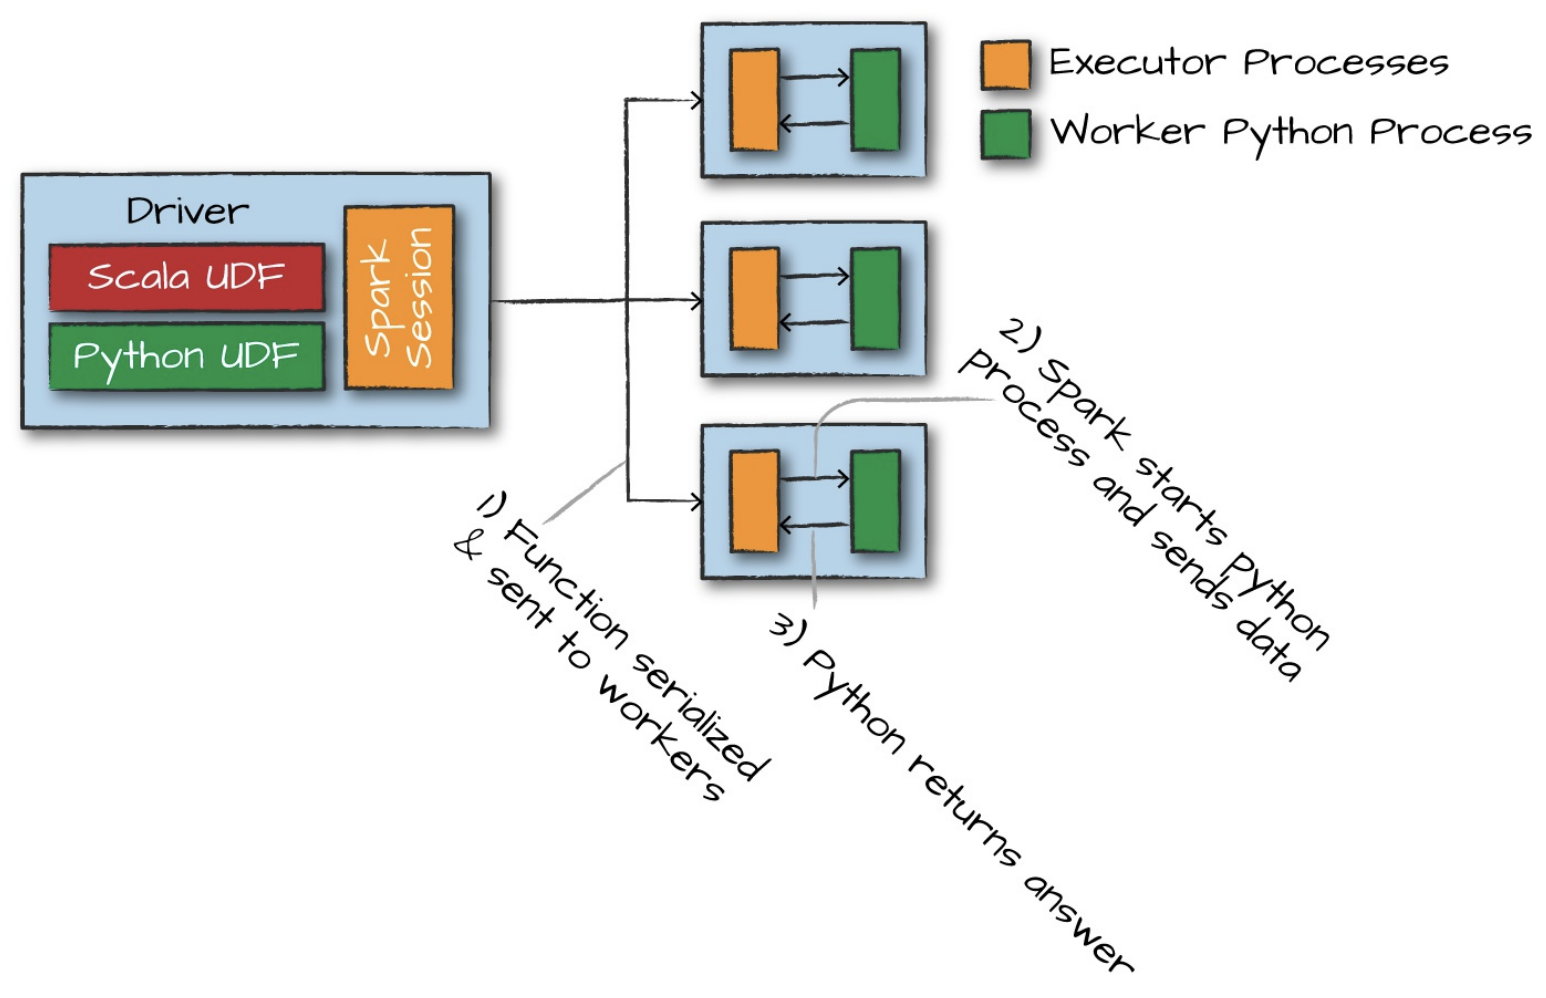


숫자를 입력받아 세제곱 연산을 하는 `power3` UDF함수를 만들어보자.

In [ ]:
udfExampleDF = spark.range(5).toDF("num")

udfExampleDF.select(col("num")).show(5)


def power3(double_value):
    return double_value **3
power3(2.0)

# udf 실행해보자. 먼저 DataFrame에 사용할 수 있게 함수를 등록한다.
from pyspark.sql.functions import udf

power3udf = udf(power3)
power3udf

from pyspark.sql.functions import col


udfExampleDF.select(col("num")).show(5)
udfExampleDF.select(power3udf(col("num"))).show(5)



아직까지는 DataFrame에서만 사용할 수 있고, 문자열 표현식에서는 사용할 수 없다. 사용자 정의 함수를 SparkSQL 에 등록하면 모든 프로그래밍 언어와 SQL에서 사용자 정의 함수를 사용할 수 있다.

Scala 를 사용해 사용자 정의 함수를 등록해보겠습니다.

```
// in Scala
spark.udf.register("power3", power3(_:Double):Double)
udfExampleDF.selectExpr("power3(num)").show(2)
```

사용자 정의 함수를 SparkSQL 함수로 등록하여 Scala 로 개발된 사용자 정의 함수를 Python 에서 우회적으로 사용할 수 있습니다. 하지만 사용자 정의 함수를 DataFrame 함수 대신 SQL 표현식으로 사용해야 합니다.

```
# in Python
udfExampleDF.selectExpr("power3(num)").show(2)
```
Python 함수를 SQL 함수로 등록할 수 있습니다.


In [ ]:
from pyspark.sql.types import IntegerType, DoubleType

# 파이썬 UDF 등록
spark.udf.register("power3py", power3, IntegerType())

# 파이썬으로 등록된 UDF 사용
udfExampleDF.selectExpr("power3py(num)").show(5)

함수가 올바르게 동작할 수 있게 반환된 실제 데이터 타입과 일치하는 데이터 타입을 지정해야합니다. 그렇지 않으면 SPARK는 오류아닌 Null을 반환한다. 아래 예제는 반환 데이터 타입을 DoubleType으로 변경하면 null 나오는거 볼 수 있다.

null값을 반환하는 이유는 `range` 메소드가 Integer 데이터 타입의 데이터를 만들기 때문이다. 
이 타입을 Float 데이터 테이블로 변환할 수 없으므로 null을 반환합니다.



In [ ]:
from pyspark.sql.types import IntegerType, DoubleType

# 파이썬 UDF 등록
spark.udf.register("power3null", power3, DoubleType())

# 파이썬으로 등록된 UDF 사용
udfExampleDF.selectExpr("power3null(num)").show(5)

SQL 에서도 등록된 사용자 정의 함수를 사용할 수 있습니다.
```
-- in SQL
SELECT power3(12), power3py(12) -- doesn't work because of return type

````
사용자 정의 함수에서 값을 선택적으로 반환하려면 Python 은 None 을 Scala 는 Option 타입을 반환해야 합니다.


Hive UDFsPermalink
Hive 문법을 사용해서 만든 UDF/UDAF 도 사용할 수 있습니다. SparkSession 을 생성할 때 SparkSession.builder().enableHiveSupport() 를 명시해 반드시 Hive 지원 기능을 활성화 해야합니다.
```
-- in SQL
CREATE TEMPORARY FUNCTION myFunc AS 'com.organization.hive.udf.Funct

```
TEMPORARY 키워드를 제거하면 Hive 메타스토어에 영구 함수로 등록됩니다.